# Travis CI Build Breaker Analysis

# Context

In the age of agile software development, continous integration became an integral part of every development team. With the time, there may be so many test jobs and nightly builds running, that many teams are wasting much time in fixing the test instead of creating new features for their customers. On top of that, in the age of distributed systems, many build jobs might simply break because an external system isn't available or is behaving erroneous. These errors are very annoying because they occur sporadic and are very hard to trace back.

In this blog post, I want to present you some options to find weird behaving build jobs. For this, I've downloaded some build log dumps from Travis Torrent, unpacked them and read them into Pandas to get some insight about breaking build jobs.

# Idea

As complex as build logs might look like, they are semi-structured texts that contain recurring information in each job run.

This means we can read a build log by a data analysis framework that can read in kind of structured data. Of course, we use Pandas for this to get our effective analysis of build logs started. In this example, I choose one of the biggest Travis CI build log archive for an Java application that I could find (I used a Google BigQuery to find the biggest ones). It's SonarQube &ndash; a static quality assurance tools for use in continuous integration (what a nice coincidence).

The idea of this notebook is to show you what kind of information you can extract from a build log file to get more insight on how your build is working or failing. I won't show you every information detail that you can extract from a build log file, because they tend to get very specific and highly dependent on your own situation. But with the "mechanics" I'll show, you can adopt some analysis to your specific needs as well.

We read in the all the files in from the build log dump with `glob`. This allows us to quickly get the relevant files.

Note: Because our log files are all in the same directory, we don't need to use the `recursive` feature that `glob` provides to get files from subdirectories as well.

In [143]:
import glob
import os
ROOT_DIR = "C:/dev/data/build_logs/SonarSource@sonar-java-light"
ROOT_DIR = "C:/dev/data/build_logs/SonarSource@sonar-java"

GLOB_PATTERN = "*.log"
log_file_paths = glob.glob(os.path.join(ROOT_DIR, GLOB_PATTERN))
log_file_paths[:5]

['C:/dev/data/build_logs/SonarSource@sonar-java\\1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925123.log',
 'C:/dev/data/build_logs/SonarSource@sonar-java\\1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925124.log',
 'C:/dev/data/build_logs/SonarSource@sonar-java\\1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925125.log',
 'C:/dev/data/build_logs/SonarSource@sonar-java\\1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925126.log',
 'C:/dev/data/build_logs/SonarSource@sonar-java\\1001_75929201_759f1ead70a1a8a8e889a5afc7f73787bb251fc3_75929202.log']

We import the raw data as soon as possible into a Pandas DataFrame to avoid custom Python glue code and to be able to use the "standardized" methods for data wrangling of the Pandas framework.

In [144]:
import pandas as pd
# set width of column for nicer output
pd.set_option('max_colwidth', 130)

raw_logs = pd.DataFrame(log_file_paths, columns=['path'])
raw_logs.head()

,path
0,C:/dev/data/build_logs/SonarSource@sonar-java\1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925123.log
1,C:/dev/data/build_logs/SonarSource@sonar-java\1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925124.log
2,C:/dev/data/build_logs/SonarSource@sonar-java\1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925125.log
3,C:/dev/data/build_logs/SonarSource@sonar-java\1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925126.log
4,C:/dev/data/build_logs/SonarSource@sonar-java\1001_75929201_759f1ead70a1a8a8e889a5afc7f73787bb251fc3_75929202.log


We clean up these ugly, different, OS-specific file separators by using a common one. 

Note: We could have also used `os.sep` that gives us the OS-specific separator. In Windows, this would be `\`. But if you plan to extract data later e. g. by regular expressions, this is getting really unreadable, because `\` is also the character to escape certain other characters.

In [145]:
raw_logs['path'] = raw_logs['path'].str.replace("\\", "/")
raw_logs.head()

,path
0,C:/dev/data/build_logs/SonarSource@sonar-java/1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925123.log
1,C:/dev/data/build_logs/SonarSource@sonar-java/1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925124.log
2,C:/dev/data/build_logs/SonarSource@sonar-java/1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925125.log
3,C:/dev/data/build_logs/SonarSource@sonar-java/1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925126.log
4,C:/dev/data/build_logs/SonarSource@sonar-java/1001_75929201_759f1ead70a1a8a8e889a5afc7f73787bb251fc3_75929202.log


The are many information in the file path alone:

* The last directory in the path contains the name of the build job
* The first part of the file name is the build number
* The second part of the file name is the build id

Let's say we need that information later on, so we extract it with a nice regular expression with named groups.

In [146]:
# TODO: uses still regex, too slow? Consider "split"?
logs = raw_logs.join(raw_logs['path'].str.extract(
        r"^.*" + \
        "/(?P<jobname>.*)/" + \
        "(?P<build_number>.*?)_" + \
        "(?P<build_id>.*?)_.*\.log$", expand=True))
logs.head()

,path,jobname,build_number,build_id
0,C:/dev/data/build_logs/SonarSource@sonar-java/1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925123.log,SonarSource@sonar-java,1000,75925122
1,C:/dev/data/build_logs/SonarSource@sonar-java/1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925124.log,SonarSource@sonar-java,1000,75925122
2,C:/dev/data/build_logs/SonarSource@sonar-java/1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925125.log,SonarSource@sonar-java,1000,75925122
3,C:/dev/data/build_logs/SonarSource@sonar-java/1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925126.log,SonarSource@sonar-java,1000,75925122
4,C:/dev/data/build_logs/SonarSource@sonar-java/1001_75929201_759f1ead70a1a8a8e889a5afc7f73787bb251fc3_75929202.log,SonarSource@sonar-java,1001,75929201


In the case of the Travis build log dumps, we got multiple files for each build run. We just need the first ones, that's why we throw away all the other build logs with the same build number.

In [147]:
logs = logs.drop_duplicates(subset=['build_number'], keep='first')
logs.head()

,path,jobname,build_number,build_id
0,C:/dev/data/build_logs/SonarSource@sonar-java/1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925123.log,SonarSource@sonar-java,1000,75925122
4,C:/dev/data/build_logs/SonarSource@sonar-java/1001_75929201_759f1ead70a1a8a8e889a5afc7f73787bb251fc3_75929202.log,SonarSource@sonar-java,1001,75929201
8,C:/dev/data/build_logs/SonarSource@sonar-java/1002_75932199_c8c445f3fc062057c8c8b85fa29cae2e3197589d_75932200.log,SonarSource@sonar-java,1002,75932199
12,C:/dev/data/build_logs/SonarSource@sonar-java/1003_75934919_d92aca4576d30ff97fcb7ed2302f5bd0f56d6438_75934920.log,SonarSource@sonar-java,1003,75934919
16,C:/dev/data/build_logs/SonarSource@sonar-java/1004_75940558_b4a51d318eb3286cc6c8f41ba54fb221573aca31_75940561.log,SonarSource@sonar-java,1004,75940558


After dropping possible multiple build log files, we can use the build number as new index (aka key) for our DataFrame.

In [148]:
logs = logs.set_index(['build_number'], drop=True)
logs.head()

,path,jobname,build_id
build_number,,,
1000,C:/dev/data/build_logs/SonarSource@sonar-java/1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925123.log,SonarSource@sonar-java,75925122
1001,C:/dev/data/build_logs/SonarSource@sonar-java/1001_75929201_759f1ead70a1a8a8e889a5afc7f73787bb251fc3_75929202.log,SonarSource@sonar-java,75929201
1002,C:/dev/data/build_logs/SonarSource@sonar-java/1002_75932199_c8c445f3fc062057c8c8b85fa29cae2e3197589d_75932200.log,SonarSource@sonar-java,75932199
1003,C:/dev/data/build_logs/SonarSource@sonar-java/1003_75934919_d92aca4576d30ff97fcb7ed2302f5bd0f56d6438_75934920.log,SonarSource@sonar-java,75934919
1004,C:/dev/data/build_logs/SonarSource@sonar-java/1004_75940558_b4a51d318eb3286cc6c8f41ba54fb221573aca31_75940561.log,SonarSource@sonar-java,75940558


So far, we've just extracted metadata from the file path of the build log files. Now we are getting to the interesting parts: Extracting information from the content of the bulid log files. For this, we need to load the content of the log files into our DataFrame.

We do this with a little helper method that simply returns the contents of a file who's file_path was given:

In [149]:
def load_file_content(file_path):
    with open(file_path, mode='r', encoding="utf-8") as f:
        return f.read()

We use the function above in the `apply` call upon the `path` Series.

Note: For many big files, this could take some time to finish.

In [150]:
logs['content'] = logs['path'].apply(load_file_content)
logs.head()

,path,jobname,build_id,content
build_number,,,,
1000,C:/dev/data/build_logs/SonarSource@sonar-java/1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925123.log,SonarSource@sonar-java,75925122,Using worker: worker-linux-docker-041074ed.prod.travis-ci.org:travis-linux-7\n\ntravis_fold:start:system_info\n[0K[33;1mBuil...
1001,C:/dev/data/build_logs/SonarSource@sonar-java/1001_75929201_759f1ead70a1a8a8e889a5afc7f73787bb251fc3_75929202.log,SonarSource@sonar-java,75929201,Using worker: worker-linux-docker-dc056135.prod.travis-ci.org:travis-linux-7\n\ntravis_fold:start:system_info\n[0K[33;1mBuil...
1002,C:/dev/data/build_logs/SonarSource@sonar-java/1002_75932199_c8c445f3fc062057c8c8b85fa29cae2e3197589d_75932200.log,SonarSource@sonar-java,75932199,Using worker: worker-linux-docker-064e2aef.prod.travis-ci.org:travis-linux-1\n\ntravis_fold:start:system_info\n[0K[33;1mBuil...
1003,C:/dev/data/build_logs/SonarSource@sonar-java/1003_75934919_d92aca4576d30ff97fcb7ed2302f5bd0f56d6438_75934920.log,SonarSource@sonar-java,75934919,Using worker: worker-linux-docker-ed1a7e04.prod.travis-ci.org:travis-linux-1\n\ntravis_fold:start:system_info\n[0K[33;1mBuil...
1004,C:/dev/data/build_logs/SonarSource@sonar-java/1004_75940558_b4a51d318eb3286cc6c8f41ba54fb221573aca31_75940561.log,SonarSource@sonar-java,75940558,Using worker: worker-linux-docker-8f1d7966.prod.travis-ci.org:travis-linux-3\n\ntravis_fold:start:system_info\n[0K[33;1mBuil...


Because it could get a little bit confusing with so much columns in a single DataFrame, we delete the `path` columns because it's not needed anymore.

In [151]:
log_data = logs.copy()
del(log_data['path'])
log_data.head()

,jobname,build_id,content
build_number,,,
1000,SonarSource@sonar-java,75925122,Using worker: worker-linux-docker-041074ed.prod.travis-ci.org:travis-linux-7\n\ntravis_fold:start:system_info\n[0K[33;1mBuil...
1001,SonarSource@sonar-java,75929201,Using worker: worker-linux-docker-dc056135.prod.travis-ci.org:travis-linux-7\n\ntravis_fold:start:system_info\n[0K[33;1mBuil...
1002,SonarSource@sonar-java,75932199,Using worker: worker-linux-docker-064e2aef.prod.travis-ci.org:travis-linux-1\n\ntravis_fold:start:system_info\n[0K[33;1mBuil...
1003,SonarSource@sonar-java,75934919,Using worker: worker-linux-docker-ed1a7e04.prod.travis-ci.org:travis-linux-1\n\ntravis_fold:start:system_info\n[0K[33;1mBuil...
1004,SonarSource@sonar-java,75940558,Using worker: worker-linux-docker-8f1d7966.prod.travis-ci.org:travis-linux-3\n\ntravis_fold:start:system_info\n[0K[33;1mBuil...


Let's have a look at some of the contents of a build log file. This is where the analysis gets very specific depending on the used contiuous integration server, the build system, the programming language etc. . But the main idea is the same: Extract some interesing features that show what's going on in your build!

Let's take a look at our scenario: A Travis CI job of a Java application that's build with Maven.

Here are the first lines of one build log.

In [152]:
# TODO put every line in a new row

This could also take a while because we are doing a string operation which is slow.  

In [166]:
entries_per_row = log_data[0:4].content.str.split("\n",expand=True)
log_rows = pd.DataFrame(entries_per_row.stack(), columns=["data"])
log_rows

data
build_number                                                                                                          
1000         0                            Using worker: worker-linux-docker-041074ed.prod.travis-ci.org:travis-linux-7
             1                                                                                                        
             2                                                                           travis_fold:start:system_info
             3                                                                 Build system information
             4                                                                                    Build language: java
             5                                                     Build image provisioning date and time
             6                                                                            Thu Feb  5 15:09:33 UTC 2015
             7                                                                   Operating System Details
             8                                                                                 Distributor ID:\tUbuntu
             9                                                                        Description:\tUbuntu 12.04.5 LTS
             10                                                                                        Release:\t12.04
             11                                                                                     Codename:\tprecise
             12                                                                             Linux Version
             13                                                                                      3.13.0-29-generic
             14                                                                         Cookbooks Version
             15                                     a68419e https://github.com/travis-ci/travis-cookbooks/tree/a68419e
             16                                                                               GCC version
             17                                                               gcc (Ubuntu/Linaro 4.6.3-1ubuntu5) 4.6.3
             18                                                      Copyright (C) 2011 Free Software Foundation, Inc.
             19                             This is free software; see the source for copying conditions.  There is NO
             20                            warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
             21                                                                                                       
             22                                                                              LLVM version
             23                                                              clang version 3.4 (tags/RELEASE_34/final)
             24                                                                       Target: x86_64-unknown-linux-gnu
             25                                                                                    Thread model: posix
             26                                                               Pre-installed Ruby versions
             27                                                                                        ruby-1.9.3-p551
             28                                                            Pre-installed Node.js versions
             29                                                                                               v0.10.36
...                                                                                                                ...
1003         2118                      [INFO] ------------------------------------------------------------------------
             2119                                                                              [INFO] Reactor Summary:
             2120                                                   

In [159]:
log_status = log_rows[log_rows[0].str.contains("Done.")]
log_status.head()

,,0
build_number,,
1000,2240,Done. Your build exited with 0.
1001,2142,Done. Your build exited with 0.
1002,2148,Done. Your build exited with 0.
1003,2146,Done. Your build exited with 0.
1004,2149,Done. Your build exited with 0.


In [ ]:
%matplotlib inline
log_status[0].value_counts().plot(kind='pie')

# Halde

Browsing manually through the log, there are some interesting features. E. g. the start time of the build.

In [102]:
print(log_data.iloc[0]['content'][1400:1800])

m
3.4.3
ElasticSearch version
1.4.0
Installed Sphinx versions
2.0.10
2.1.9
2.2.6
Default Sphinx version
2.2.6
Installed Firefox version
firefox 31.0esr
PhantomJS version
1.9.8
ant -version
Apache Ant(TM) version 1.8.2 compiled on December 3 2011
mvn -version
Apache Maven 3.2.5 (12a6b3acb947671f09b81f49094c53


So let's check for some errors and warnings. For this, we create a new DataFrame because it's another kind of information.

In [66]:
logs['finished'] = logs.content.str[-100:].str.extract("(.*)\n*$", expand=False)
pd.DataFrame(logs['finished'].value_counts().head(10))

,finished
Done. Your build exited with 0.,13


In [67]:
mapping = {
    "Done. Your build exited with 0." : "SUCCESS",
    "Done. Build script exited with: 0" : "SUCCESS",
    "Done. Build script exited with 0" : "SUCCUESS",
    "Your build has been stopped." : "STOPPED",
    "The build has been terminated." : "TERMINATED",
    "The build has been terminated" : "TERMINATED",
    "Done. Your build exited with 1." : "ERROR",
    "Done. Build script exited with: 1" : "ERROR",
    "Your test run exceeded " : "ABORTED"
}
logs['finished_state'] = logs['finished'].map(mapping)
logs.loc[logs['finished_state'].isnull(), "finished_state"] = "UNKNOWN"
logs['finished_state'].value_counts()

SUCCESS    13
Name: finished_state, dtype: int64

In [68]:
logs['start_time'] = logs['content'].str.extract(
    r"travis_time:end:.*:start=([0-9]*),", expand=False)
logs['start_time'].head()

build_number
6610    1472567319865893268
6611    1472570558350928150
6612    1472628804165373512
6613    1472629132020359360
6614    1472629125819446553
Name: start_time, dtype: object

In [69]:
logs['start_time'] = pd.to_datetime(
    pd.to_numeric(
        logs['start_time'])/1000, unit='us')
logs['start_time'].head()

build_number
6610   2016-08-30 14:28:39.865893500
6611   2016-08-30 15:22:38.350928250
6612   2016-08-31 07:33:24.165373500
6613   2016-08-31 07:38:52.020359500
6614   2016-08-31 07:38:45.819446500
Name: start_time, dtype: datetime64[ns]

In [70]:
logs['end_time'] = logs['content'].str[-500:].str.extract(
    r"travis_time:end:.*:start=[0-9]*,finish=([0-9]*)",expand=True)
logs['end_time'] = pd.to_datetime(pd.to_numeric(logs['end_time'])/1000, unit='us')
logs['end_time'].head()

build_number
6610   2016-08-30 14:36:03.042701500
6611   2016-08-30 15:26:39.847178500
6612   2016-08-31 07:43:35.264666000
6613   2016-08-31 07:44:51.646482250
6614   2016-08-31 07:45:01.246372750
Name: end_time, dtype: datetime64[ns]

In [71]:
logs['duration'] = logs['end_time'] - logs['start_time']

In [72]:
successful_builds = logs[logs['finished_state'] == "SUCCESS"].dropna()
successful_builds['duration'].mean()

Timedelta('0 days 00:08:02.750802')

In [73]:
len(logs)

13

In [74]:
t = successful_builds['duration']
t.memory_usage()

208

In [75]:
successful_builds['duration_in_min'] = successful_builds['duration'].astype('timedelta64[m]')
successful_builds['duration_in_min'].head()

build_number
6610     7.0
6611     4.0
6612    10.0
6613     5.0
6614     6.0
Name: duration_in_min, dtype: float64

In [76]:
successful_builds_over_time = successful_builds.reset_index().set_index(pd.DatetimeIndex(successful_builds['start_time'])).resample('1W').mean()
successful_builds_over_time.head()

,duration_in_min
start_time,
2016-09-04,7.538462


# Visualisierung

C:\dev\apps\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=2436.0, right=2436.0
  'left=%s, right=%s') % (left, right))


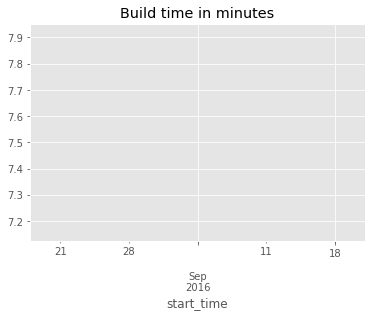

In [77]:
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
successful_builds_over_time['duration_in_min'].plot(
    title="Build time in minutes")